## Import packages

In [1]:
import osmnx as ox, networkx as nx, numpy as np, pandas as pd, geopandas as gpd, random, math
import matplotlib.pyplot as plt, matplotlib.colors as mcolors
from shapely.geometry import Point
from shapely.ops import transform
from scipy.spatial import cKDTree
from itertools import cycle
from pathlib import Path
from collections import defaultdict
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import MinMaxScaler
import pyproj
import folium
from folium import GeoJson, CircleMarker, Marker, PolyLine, Icon, DivIcon
from folium.plugins import MarkerCluster
from matplotlib.lines import Line2D

## Load data

In [2]:
def cargar_geojson(nombre_archivo, directorio_base='../../../../data/delivetter'):
    """
    Carga un archivo GeoJSON específico y devuelve un GeoDataFrame.
    
    Args:
        nombre_archivo (str): Nombre del archivo GeoJSON (ej. 'barris.geojson').
        directorio_base (str): Ruta relativa al directorio donde se encuentra el archivo.
                              Por defecto: '../../data/delivetter'.
    
    Returns:
        gpd.GeoDataFrame: GeoDataFrame con los datos del archivo.
        None: Si el archivo no existe o hay un error.
    """
    try:
        ruta = Path(directorio_base) / nombre_archivo
        
        if not ruta.exists():
            raise FileNotFoundError(f"Archivo no encontrado: {ruta.absolute()}")
        
        gdf = gpd.read_file(ruta)
        print(f"✅ '{nombre_archivo}' cargado correctamente ({len(gdf)} registros)")
        return gdf
    
    except Exception as e:
        print(f"❌ Error al cargar '{nombre_archivo}': {str(e)}")
        return None
    
barrios = cargar_geojson('barris.geojson')
catastro = cargar_geojson('catastro.geojson')
puntos_carga = cargar_geojson('puntosCID.geojson')

✅ 'barris.geojson' cargado correctamente (88 registros)
✅ 'catastro.geojson' cargado correctamente (36346 registros)
✅ 'puntosCID.geojson' cargado correctamente (885 registros)


## Graph request and data integration

In [3]:
def get_graph(request):
    shp_neighbourhood = barrios[barrios["nombre"].str.upper().str.contains(request.strip().upper())]
    while len(shp_neighbourhood) != 1:
        request = input("Please, introduce a valid neighbourhood: ")
        shp_neighbourhood = barrios[barrios["nombre"].str.upper().str.contains(request.strip().upper())]
    shp_zone = shp_neighbourhood["geometry"].values[0]
    shp_loading_points = puntos_carga[puntos_carga.intersects(shp_zone)]
    shp_bajos = catastro[catastro.intersects(shp_zone)]

    G = ox.graph_from_polygon(shp_zone, 
                              network_type="all_public",  
                              simplify=False, 
                              retain_all=False,  
                              truncate_by_edge=True) 
    not_highway = ['elevator', 'busway', 'corridor', 'unclassified', 'services', 'cycleway', 'steps', 'service']

    allowed_vehicle = ['motorway', 'residential', 'secondary', 'living_street',
                    'primary_link', 'primary', 'tertiary', 'trunk', 'service',
                    'tertiary_link', 'trunk_link', 'secondary_link', 'motorway_link', 'road']
    
    allowed_pedestrian = ["pedestrian", "footway", "path", "track", "bridleway", "living_street", "residential"]
    edges_to_remove = [(u, v, k) for u, v, k, data in G.edges(keys=True, data=True) 
                   if data.get('highway') in not_highway or data.get('access') in ['private', 'no', 'customers']]
    G.remove_edges_from(edges_to_remove)

    G_vehicle = G.copy()  
    edges_to_remove_vehicle = [(u, v, k) for u, v, k, data in G_vehicle.edges(keys=True, data=True) 
                                   if data.get('highway') not in allowed_vehicle]
    G_vehicle.remove_edges_from(edges_to_remove_vehicle)
    
    G_pedestrian = G.copy()  
    edges_to_remove_pedestrian = [(u, v, k) for u, v, k, data in G_pedestrian.edges(keys=True, data=True) 
                                      if data.get('highway') not in allowed_pedestrian]
    G_pedestrian.remove_edges_from(edges_to_remove_pedestrian)

    for graph in [G_vehicle, G_pedestrian]:
        nodes_to_remove = [node for node in graph.nodes if graph.degree(node) == 0]
        graph.remove_nodes_from(nodes_to_remove)

    for u, v, k, data in G_pedestrian.edges(keys=True, data=True):
        data['oneway'] = False

    G_vehicle = G_vehicle.subgraph(max(nx.weakly_connected_components(G_vehicle), key=len)).copy()
    G_pedestrian = G_pedestrian.subgraph(max(nx.weakly_connected_components(G_pedestrian), key=len)).copy()


    print(f"Vehicle graph: {len(G_vehicle.nodes)} nodes, {len(G_vehicle.edges)} edges")
    print(f"Pedestrian graph: {len(G_pedestrian.nodes)} nodes, {len(G_pedestrian.edges)} edges")
    

    # Figura para el grafo de vehículos
    fig1, ax1 = plt.subplots(figsize=(20, 7))
    ax1.set_title("Drive graph")
    ox.plot_graph(G_vehicle, ax=ax1, node_size=3, node_color='green', 
                edge_linewidth=0.5, edge_color='blue', bgcolor="white", show=False)
    plt.show()

    # Figura para el grafo de peatones
    fig2, ax2 = plt.subplots(figsize=(20, 7))
    ax2.set_title("Pedestrian graph")
    ox.plot_graph(G_pedestrian, ax=ax2, node_size=3, node_color='green', 
                edge_linewidth=0.5, edge_color='red', bgcolor="white", show=False)
    plt.show()

    
    

    return G_vehicle, G_pedestrian, shp_zone, shp_loading_points, shp_bajos
    


def graph_map(G_vehicle, G_pedestrian, shp_zone, shp_loading_points, bajos):
    mapa = folium.Map(location=[shp_zone.centroid.y, shp_zone.centroid.x], zoom_start=16)

    gdf_edges_vehicle = ox.graph_to_gdfs(G_vehicle, nodes=False, edges=True)
    gdf_edges_pedestrian = ox.graph_to_gdfs(G_pedestrian, nodes=False, edges=True)

    bajos_in_zone = bajos[bajos.intersects(shp_zone)]

    folium.GeoJson(
        shp_zone,  
        style_function=lambda feature: {
            "color": "green", 
            "weight": 6,  
            "fill": True,  
            "fillColor": "limegreen",  
            "fillOpacity": 0.2  
        }
    ).add_to(mapa)
    
    def add_edges_with_popup(gdf_edges, color, group_name):
        for _, row in gdf_edges.iterrows():
            if row["geometry"].geom_type == "LineString":
                popup_text = f"<b>Tipo:</b> {row.get('highway', 'N/A')}<br>"
                popup_text += f"<b>Nombre:</b> {row.get('name', 'Sin nombre')}<br>"
                popup_text += f"<b>Longitud:</b> {round(row.get('length', 0), 1)} m"

                folium.GeoJson(
                    row["geometry"],
                    name=group_name,
                    style_function=lambda feature, col=color: {
                        'color': col,
                        'weight': 2,
                        'opacity': 1
                    },
                    tooltip=popup_text
                ).add_to(mapa)
    add_edges_with_popup(gdf_edges_pedestrian, "red", "Peatones")
    add_edges_with_popup(gdf_edges_vehicle, "blue", "Vehículos")
    

    

    shp_loading_points.apply(lambda row: folium.CircleMarker(
        location=[row.geometry.centroid.y, row.geometry.centroid.x], 
        radius=6,  
        color="black",  
        fill=True,
        fill_color="orange",  
        fill_opacity=1, 
        popup=row.get("NOMBRE", "Punto de carga")
    ).add_to(mapa), axis=1)

    # Puntos bajos
    for _, row in bajos_in_zone.iterrows():
        if not row['Almacen'] and not row['Comercio']:
            continue

        centroide = row.geometry.centroid
        if row['Almacen'] and row['Comercio']:
            fill_color = 'black'
            tipo = "Almacén y Comercio"
        elif row['Almacen']:
            fill_color = 'purple'
            tipo = "Almacén"
        elif row['Comercio']:
            fill_color = 'lightblue'
            tipo = "Comercio"

        folium.CircleMarker(
            location=[centroide.y, centroide.x],
            radius=6,
            color='black',
            fill=True,
            fill_color=fill_color,
            fill_opacity=1,
            popup=tipo
        ).add_to(mapa)

    legend_html = '''
                <div style="position: fixed; 
                            bottom: 50px; left: 50px; width: 250px; height: 130px; 
                            background-color: white; z-index:9999; font-size:13px;
                            border:1px solid grey; border-radius: 5px; padding: 8px;
                            box-shadow: 2px 2px 5px rgba(0,0,0,0.2);">
                    <b style="font-size:14px;">Legend</b> <br>
                    <i class="fa fa-circle" style="color:black; margin-right:5px;"></i> Warehouse & Store <br>
                    <i class="fa fa-circle" style="color:orange; margin-right:5px;"></i> CiD Point <br>
                    <i class="fa fa-circle" style="color:purple; margin-right:5px;"></i> Warehouse <br>
                    <i class="fa fa-circle" style="color:lightblue; margin-right:5px;"></i> Store (delivery point) <br>
                    <i class="fa fa-square" style="color:limegreen; margin-right:5px;"></i> Neigborhood boundary
                </div>
                '''

    mapa.get_root().html.add_child(folium.Element(legend_html))
    
    return mapa




| FAVARA               | BENICALAP             | SANT PAU                 | BORBOTO                  | BENIFARAIG               |
|----------------------|----------------------|--------------------------|--------------------------|--------------------------|
| CAMI REAL           | JAUME ROIG            | LA SEU                   | AIORA                    | TORMOS                   |
| LA FONTETA S.LLUIS  | LA PETXINA            | L'HORT DE SENABRE        | CIUTAT JARDI             | CAMI DE VERA             |
| LA PUNTA            | SANT MARCEL.LI        | FAITANAR                 | PINEDO                   | CASTELLAR-L'OLIVERAL     |
| BENIMAMET           | EL FORN D'ALCEDO      | MONTOLIVET               | CIUTAT DE LES ARTS I DE LES CIENCIES | NA ROVELLA             |
| SANT LLORENS        | NATZARET              | LA CREU COBERTA          | L'AMISTAT                | EL GRAU                  |
| CIUTAT FALLERA      | RAFALELL-VISTABELLA   | LA CARRASCA              | BENIFERRI                | EL SALER                 |
| NOU MOLES           | MORVEDRE              | TRINITAT                 | CAMPANAR                 | EL CARME                 |
| LA LLUM             | LA VEGA BAIXA         | LA XEREA                 | L'ILLA PERDUDA           | TRES FORQUES             |
| LA MALVA-ROSA       | EL MERCAT             | LA ROQUETA               | LA GRAN VIA              | CAMI FONDO               |
| EL CALVARI          | LA RAIOSA             | SAFRANAR                 | SANT ISIDRE              | MALILLA                  |
| LES TENDETES        | PATRAIX               | RUSSAFA                  | LA CREU DEL GRAU         | LES CASES DE BARCENA     |
| CIUTAT UNIVERSITARIA | MAHUELLA-TAULADELLA  | MASSARROJOS              | CARPESA                  | TORREFIEL                |
| EL BOTANIC          | SANT ANTONI           | BENIMACLET               | MARXALENES               | EXPOSICIO                |
| BETERO              | CABANYAL-CANYAMELAR   | MESTALLA                 | EL PILAR                 | EL PLA DEL REMEI         |
| ALBORS              | ARRANCAPINS           | EN CORTS                 | POBLE NOU                | LA TORRE                 |
| SANT FRANCESC       | PENYA-ROJA            | ELS ORRIOLS              | VARA DE QUART            | SOTERNES                 |
| LA FONTSANTA        | EL PERELLONET         | EL PALMAR                | LA XEREA                 | L'ILLA PERDUDA           |


Vehicle graph: 427 nodes, 466 edges
Pedestrian graph: 1315 nodes, 2850 edges


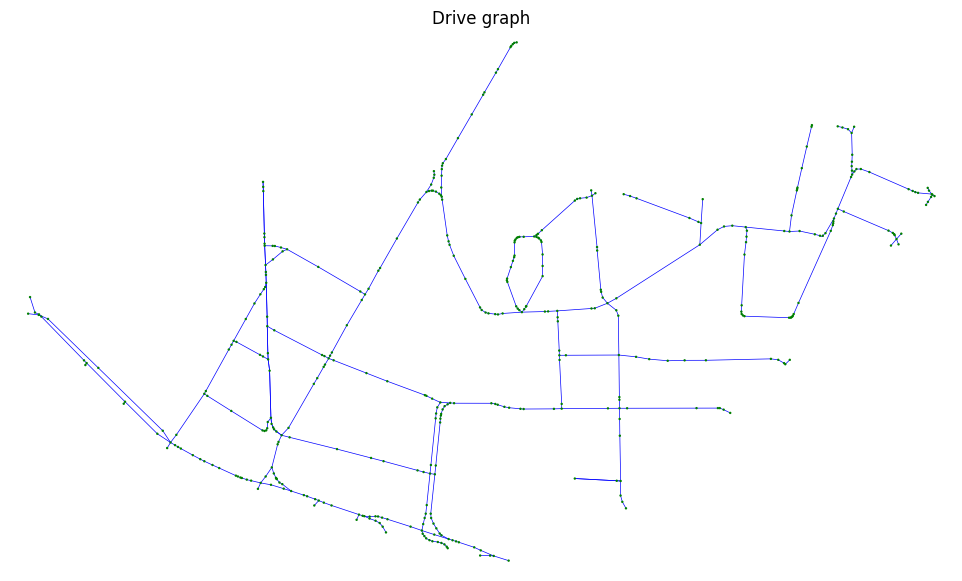

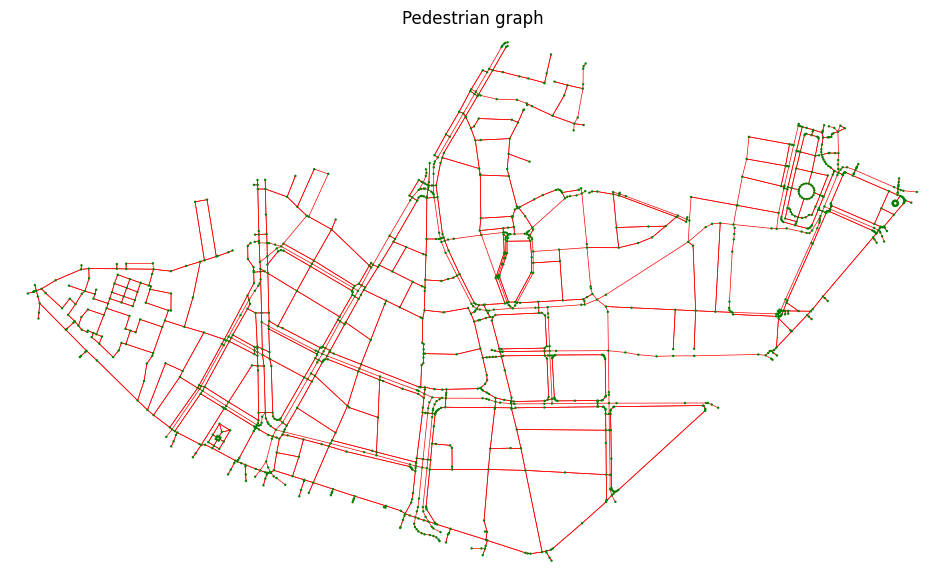

In [4]:
G_drive, G_walk, shp_zone, shp_loading_points, shp_bajos= get_graph('SANT FRANCESC')
graph_map(G_drive, G_walk, shp_zone, shp_loading_points, shp_bajos)

## Supergraph building

In [5]:

# ==============================
# 1. Crear el supergrafo fusionando aristas
# ==============================

G_super = nx.MultiDiGraph()

# Agregar todos los nodos
G_super.add_nodes_from(G_drive.nodes(data=True))
G_super.add_nodes_from(G_walk.nodes(data=True))

# Función para añadir o fusionar aristas
def add_or_merge_edge(G, u, v, k, data, mode):
    data = data.copy()
    if 'mode' in data:
        current_mode = data['mode']
        if not isinstance(current_mode, list):
            data['mode'] = [current_mode]
    else:
        data['mode'] = []

    if mode not in data['mode']:
        data['mode'].append(mode)

    # Verifica si ya existe una arista idéntica en términos de u-v
    exists = False
    for key_existing in G[u][v] if G.has_edge(u, v) else []:
        existing_data = G[u][v][key_existing]
        if existing_data.get('geometry') == data.get('geometry'):
            # Fusionar modos
            if 'mode' in existing_data:
                for m in data['mode']:
                    if m not in existing_data['mode']:
                        existing_data['mode'].append(m)
            else:
                existing_data['mode'] = data['mode']
            exists = True
            break

    if not exists:
        G.add_edge(u, v, key=k, **data)

# Añadir aristas de G_drive
for u, v, k, data in G_drive.edges(keys=True, data=True):
    add_or_merge_edge(G_super, u, v, k, data, 'drive')

# Añadir aristas de G_walk
for u, v, k, data in G_walk.edges(keys=True, data=True):
    add_or_merge_edge(G_super, u, v, k, data, 'walk')
    if not G_walk.has_edge(v, u):
        add_or_merge_edge(G_super, v, u, k, data, 'walk')
    

# ==============================
# 2. Preparar k-d trees para búsquedas rápidas
# ==============================

G_drive_proj = ox.project_graph(G_drive)
G_walk_proj = ox.project_graph(G_walk)

nodes_drive = ox.graph_to_gdfs(G_drive_proj, edges=False)
nodes_walk = ox.graph_to_gdfs(G_walk_proj, edges=False)

coords_drive = np.vstack((nodes_drive['x'], nodes_drive['y'])).T
coords_walk = np.vstack((nodes_walk['x'], nodes_walk['y'])).T

kdtree_drive = cKDTree(coords_drive)
kdtree_walk = cKDTree(coords_walk)

index_to_node_drive = np.array(nodes_drive.index)
index_to_node_walk = np.array(nodes_walk.index)

project_geom = pyproj.Transformer.from_crs("EPSG:4326", nodes_drive.crs, always_xy=True).transform

# ==============================
# 3. Añadir nodos especiales
# ==============================

def add_special_node(G, geom, tipo, id_):
    nodo_id = f"{tipo}_{id_}"
    G.add_node(nodo_id, x=geom.centroid.x, y=geom.centroid.y, tipo=tipo)

    geom_proj = transform(project_geom, geom.centroid)
    x, y = geom_proj.x, geom_proj.y

    conexiones = []

    if tipo == "carga":
        # Conectar al nodo más cercano en drive
        dist_drive, idx_drive = kdtree_drive.query([x, y])
        nearest_drive = index_to_node_drive[idx_drive]
        conexiones.append((nearest_drive, 'drive', dist_drive))

        # Conectar al nodo más cercano en walk
        dist_walk, idx_walk = kdtree_walk.query([x, y])
        nearest_walk = index_to_node_walk[idx_walk]
        conexiones.append((nearest_walk, 'walk', dist_walk))
    
    else: # Almacén o Comercio
        # Solo se conecta a red peatonal
        dist, idx = kdtree_walk.query([x, y])
        nearest = index_to_node_walk[idx]
        conexiones.append((nearest, 'walk', dist))

    for nearest, modo, dist in conexiones:
        G.add_edge(nodo_id, nearest, mode=['connection', modo], length=dist)
        G.add_edge(nearest, nodo_id, mode=['connection', modo], length=dist)

    return nodo_id


# ==============================
# 4. Añadir todos los nodos especiales
# ==============================

nodos_carga = []
for i, row in shp_loading_points.iterrows():
    nodo = add_special_node(G_super, row.geometry, "carga", i)
    nodos_carga.append(nodo)

nodos_comercios = []
for i, row in shp_bajos[shp_bajos['Comercio'] == True].iterrows():
    nodo = add_special_node(G_super, row.geometry, "comercio", i)
    nodos_comercios.append(nodo)

nodos_almacenes = []
for i, row in shp_bajos[shp_bajos['Almacen'] == True].iterrows():
    nodo = add_special_node(G_super, row.geometry, "almacen", i)
    nodos_almacenes.append(nodo)

print(f"✅ Supergraph created with {len(G_super.nodes)} nodes and {len(G_super.edges)} edges.")


✅ Supergraph created with 1731 nodes and 4050 edges.


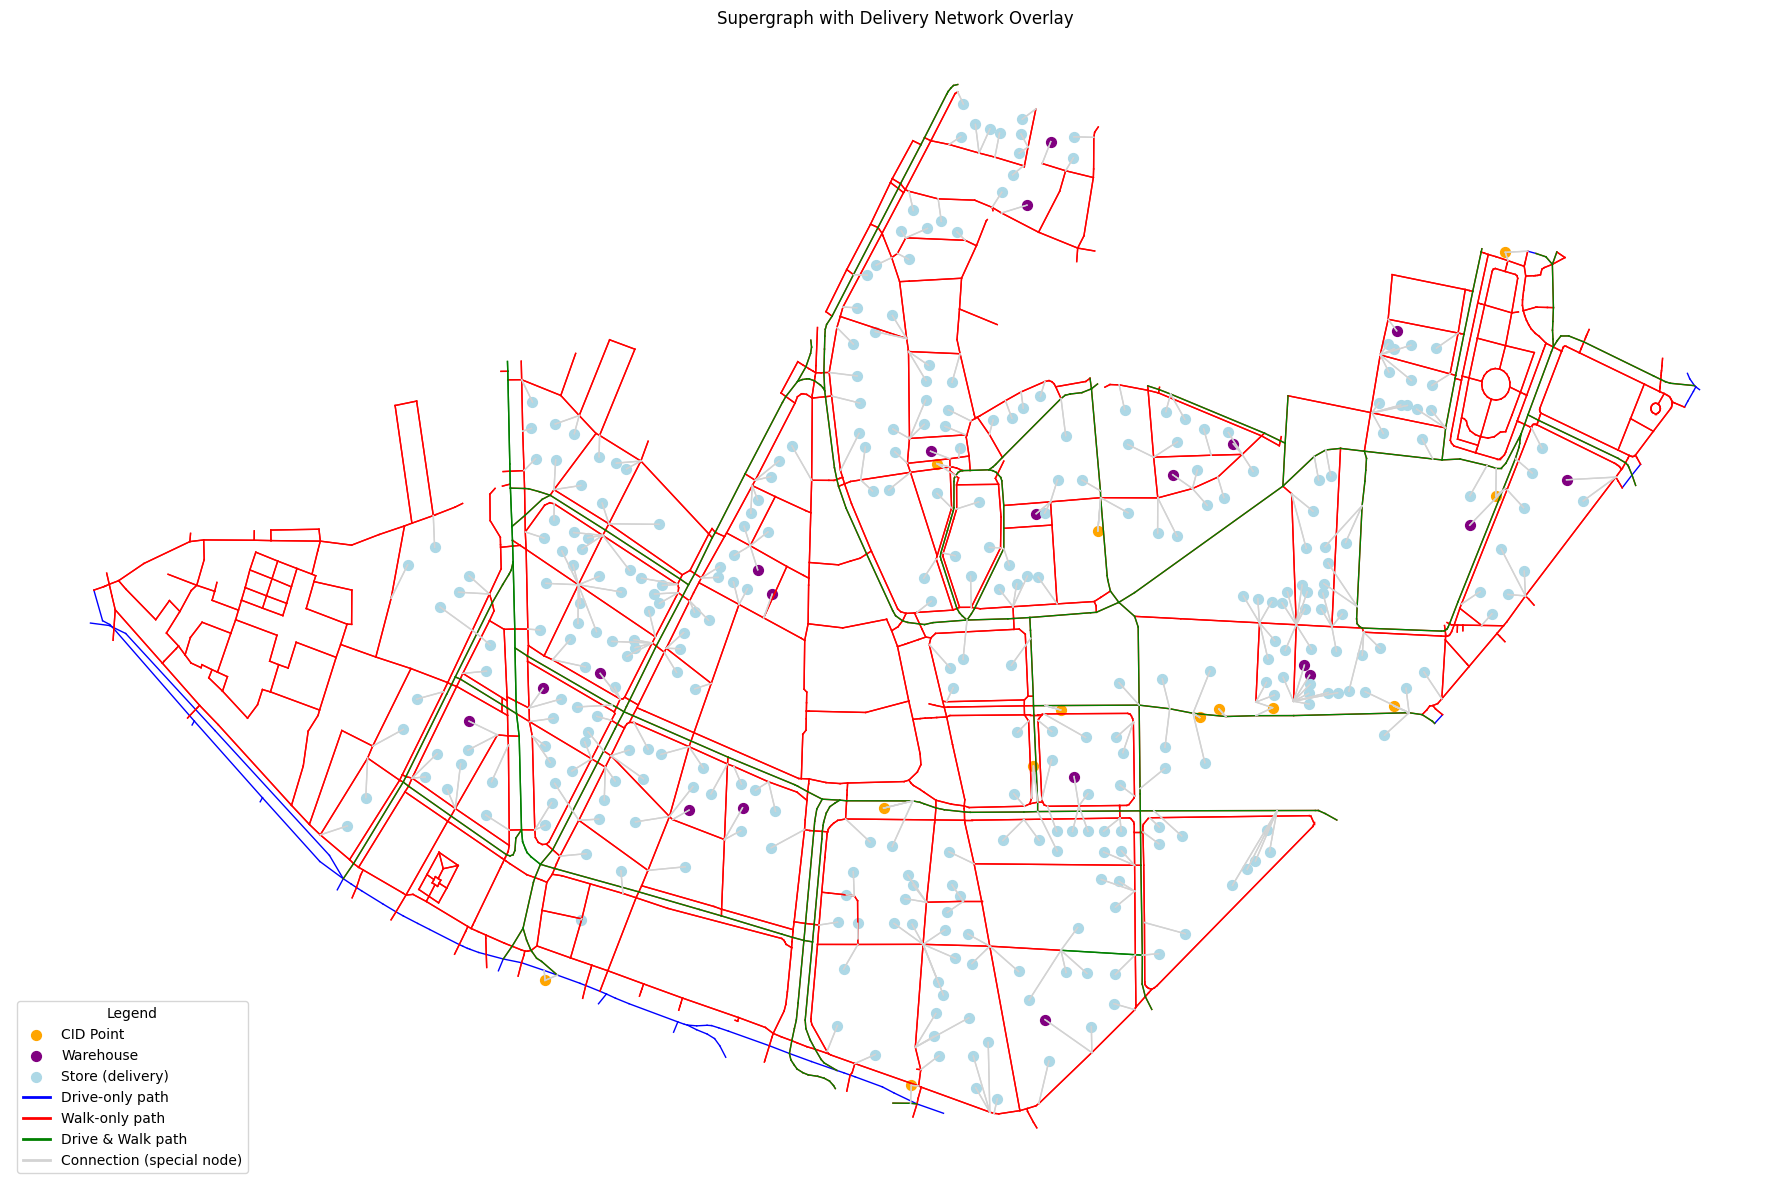

In [6]:

fig, ax = plt.subplots(figsize=(18, 12))

# ==========================
# 1. Pintar aristas por tipo
# ==========================

# Colores por modo
edge_colors = {
    'drive': 'blue',
    'walk': 'red',
    'drive+walk': 'green',
    'connection': 'lightgray'
}

# Organizar aristas por tipo (clave: modo, valor: lista de segmentos)
edges_by_mode = {k: [] for k in edge_colors}

for u, v, data in G_super.edges(data=True):
    mode = data.get('mode', 'connection')

    if isinstance(mode, list):
        if sorted(mode) == ['drive', 'walk']:
            mode_key = 'drive+walk'
        elif 'connection' in mode:
            mode_key = 'connection'
        elif 'drive' in mode:
            mode_key = 'drive'
        elif 'walk' in mode:
            mode_key = 'walk'
    else:
        mode_key = mode

    x0, y0 = G_super.nodes[u]['x'], G_super.nodes[u]['y']
    x1, y1 = G_super.nodes[v]['x'], G_super.nodes[v]['y']
    edges_by_mode[mode_key].append(([x0, x1], [y0, y1]))

# Pintar las líneas por modo
for mode_key, lines in edges_by_mode.items():
    for x_vals, y_vals in lines:
        ax.plot(x_vals, y_vals, color=edge_colors[mode_key], linewidth=1)

# ==========================
# 2. Pintar nodos según leyenda
# ==========================

categorias = {
    'cid': {'coords': [], 'color': 'orange', 'label': 'CID Point'},
    'almacen_m3': {'coords': [], 'color': 'purple', 'label': 'Warehouse'},
    'comercio_entrega': {'coords': [], 'color': 'lightblue', 'label': 'Store (delivery)'},
    'almacen_y_comercio': {'coords': [], 'color': 'black', 'label': 'Warehouse & Shop'},
}

for nodo, data in G_super.nodes(data=True):
    if isinstance(nodo, str):
        tipo = data.get('tipo')
        if tipo == 'carga':
            categorias['cid']['coords'].append((data['x'], data['y']))
        elif tipo == 'almacen' and 'comercio' in nodo:
            categorias['almacen_y_comercio']['coords'].append((data['x'], data['y']))
        elif tipo == 'almacen':
            categorias['almacen_m3']['coords'].append((data['x'], data['y']))
        elif tipo == 'comercio':
            categorias['comercio_entrega']['coords'].append((data['x'], data['y']))

# Pintar nodos especiales
for cat in categorias.values():
    if cat['coords']:
        xs, ys = zip(*cat['coords'])
        ax.scatter(xs, ys, color=cat['color'], s=50, label=cat['label'])

# ==========================
# 3. Añadir leyenda de aristas
# ==========================

edge_legend = [
    Line2D([0], [0], color='blue', lw=2, label='Drive-only path'),
    Line2D([0], [0], color='red', lw=2, label='Walk-only path'),
    Line2D([0], [0], color='green', lw=2, label='Drive & Walk path'),
    Line2D([0], [0], color='lightgray', lw=2, label='Connection (special node)'),
]

# ==========================
# 4. Estilo y leyenda
# ==========================

ax.set_title("Supergraph with Delivery Network Overlay")
ax.axis('off')

# Fusionar leyendas
handles_nodes, labels_nodes = ax.get_legend_handles_labels()
handles = handles_nodes + edge_legend
labels = labels_nodes + [h.get_label() for h in edge_legend]

# Eliminar duplicados
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys(), loc='lower left', title='Legend')

plt.tight_layout()
plt.show()



## M2 Pipeline

### 0 Configuration

In [134]:
# ==============================
# CONFIGURACIÓN
# ==============================

N_PAQUETES = 40                # Número total de paquetes a repartir
PAQUETES_MIN = 1               # Mínimo de paquetes por comercio
PAQUETES_MAX = 5               # Máximo de paquetes por comercio
CAPACIDAD_MAXIMA_WALK = 8      # Capacidad máxima que puede cargar el repartidor
CAPACIDAD_MAXIMA_ONA = 20      # Capacidad máxima que puede cargar el robot
VELOCIDAD_VEHICULO = 35        # Velocidad de la furgoneta en km/h si no hay en la arista max_speed
VELOCIDAD_PEATON = 5           # Velocidad del repartidor a pie en km/h
VELOCIDAD_CONEXION = 10        # Velocidad de las aristas de conexión en modo drive km/h


### 1 Deliveries sample

In [135]:
# ==============================
# Seleccionar comercios y asignar paquetes
# ==============================

paquetes_asignados = 0
bajos_seleccionados = []
paquetes_por_nodo = []

comercios_disponibles = nodos_comercios.copy()
random.shuffle(comercios_disponibles)

while paquetes_asignados < N_PAQUETES and comercios_disponibles:
    nodo = comercios_disponibles.pop()
    paquetes_restantes = N_PAQUETES - paquetes_asignados
    paquetes_maximos_posibles = min(PAQUETES_MAX, paquetes_restantes)

    if paquetes_maximos_posibles < PAQUETES_MIN:
        break  # No se puede asignar el mínimo a un nuevo comercio

    paquetes = random.randint(PAQUETES_MIN, paquetes_maximos_posibles)
    bajos_seleccionados.append(nodo)
    paquetes_por_nodo.append(paquetes)
    paquetes_asignados += paquetes

# Crear GeoDataFrame con los comercios seleccionados y sus paquetes
df = pd.DataFrame([{'nodo': n, **G_super.nodes[n]} for n in bajos_seleccionados])
bajos_sample = gpd.GeoDataFrame(df, geometry=[Point(row['x'], row['y']) for _, row in df.iterrows()], crs="EPSG:4326")
bajos_sample['paquetes'] = paquetes_por_nodo
display(bajos_sample)



nodo         x          y      tipo                   geometry  \
0   comercio_19647 -0.376675  39.468441  comercio  POINT (-0.37668 39.46844)   
1   comercio_21892 -0.371410  39.469937  comercio  POINT (-0.37141 39.46994)   
2   comercio_19669 -0.375369  39.471128  comercio  POINT (-0.37537 39.47113)   
3   comercio_16400 -0.380097  39.469542  comercio   POINT (-0.3801 39.46954)   
4   comercio_20349 -0.374692  39.469660  comercio  POINT (-0.37469 39.46966)   
5   comercio_19626 -0.375280  39.467672  comercio  POINT (-0.37528 39.46767)   
6   comercio_21925 -0.372373  39.470597  comercio   POINT (-0.37237 39.4706)   
7   comercio_23323 -0.370315  39.470685  comercio  POINT (-0.37032 39.47069)   
8   comercio_17699 -0.378000  39.470423  comercio    POINT (-0.378 39.47042)   
9   comercio_21141 -0.373459  39.471656  comercio  POINT (-0.37346 39.47166)   
10  comercio_17120 -0.379054  39.471233  comercio  POINT (-0.37905 39.47123)   
11  comercio_19653 -0.375542  39.468607  comercio  POINT (-0.37554 39.46861)   
12  comercio_19705 -0.376017  39.472679  comercio  POINT (-0.37602 39.47268)   
13  comercio_19727 -0.375175  39.473485  comercio  POINT (-0.37517 39.47349)   
14  comercio_17685 -0.378547  39.469082  comercio  POINT (-0.37855 39.46908)   
15  comercio_21906 -0.372630  39.469893  comercio  POINT (-0.37263 39.46989)   
16  comercio_23319 -0.370153  39.471473  comercio  POINT (-0.37015 39.47147)   

    paquetes  
0          4  
1          3  
2          1  
3          1  
4          3  
5          5  
6          1  
7          4  
8          1  
9          1  
10         1  
11         1  
12         4  
13         5  
14         2  
15         2  
16         1

### 2 Hub selection

In [136]:


# 1. Filtrar sólo los nodos que sean almacén
almacenes = [n for n, d in G_super.nodes(data=True) if d.get('tipo') == 'almacen']
if not almacenes:
    raise ValueError("No hay nodos con tipo 'almacen' en G_super.")

CANDIDATOS = min(5, len(almacenes))  # Número de almacenes a seleccionar

# 2. Calcular el centroide del grafo (media de todas las coordenadas de nodos)
xs = [data['x'] for _, data in G_super.nodes(data=True)]
ys = [data['y'] for _, data in G_super.nodes(data=True)]
centroide = Point(np.mean(xs), np.mean(ys))

# 3. Medir la distancia euclídea de cada almacén al centroide
distancias = []
for n in almacenes:
    pt = Point(G_super.nodes[n]['x'], G_super.nodes[n]['y'])
    dist = centroide.distance(pt)
    distancias.append((n, dist))

# 4. Tomar los 5 almacenes más cercanos
candidatos = sorted(distancias, key=lambda x: x[1])[:CANDIDATOS]
almacenes_cercanos = [n for n, _ in candidatos]

# 5. Elegir uno al azar
hub = random.choice(almacenes_cercanos)

print("📦 Candidates (5 most central hubs):", almacenes_cercanos)
print("✅ Selected hub:", hub)



📦 Candidates (5 most central hubs): ['almacen_19666', 'almacen_20390', 'almacen_18736', 'almacen_20357', 'almacen_18732']
✅ Selected hub: almacen_20390


### 3 Clusters

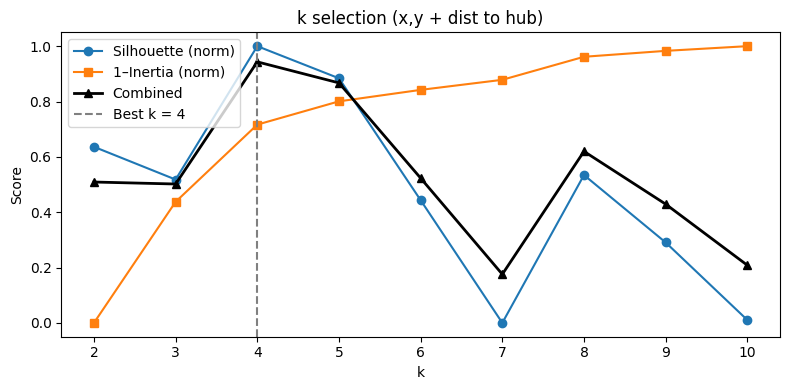

✅ Assigned to 4 robots using distance to hub.


In [137]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import MinMaxScaler

# -------------------------------------------------------------------
# 1) Definir el hub (el almacén escogido aleatoriamente de entre los 5 más centrales)
#    Supongamos que ya tienes una lista `top5_almacenes` y elegimos uno:
# -------------------------------------------------------------------
# hub = random.choice(top5_almacenes)

hub_x = G_super.nodes[hub]['x']
hub_y = G_super.nodes[hub]['y']

# -------------------------------------------------------------------
# 2) Calcular distancia euclídea de cada comercio al hub
# -------------------------------------------------------------------
xs = bajos_sample.geometry.x.values
ys = bajos_sample.geometry.y.values
dists = np.hypot(xs - hub_x, ys - hub_y)

# -------------------------------------------------------------------
# 3) Montar matriz de features: [x, y, dist_to_hub]
# -------------------------------------------------------------------
features = np.vstack([xs, ys, dists]).T

# -------------------------------------------------------------------
# 4) Función para estimar k óptimo combinando Silhouette e Inercia
# -------------------------------------------------------------------
def estimate_best_k(feats, k_min=2, k_max=10, alpha=0.5):
    ks, sils, ines = [], [], []
    for k in range(k_min, min(k_max+1, len(feats))):
        km = KMeans(n_clusters=k, random_state=42).fit(feats)
        lbl = km.labels_
        sil = silhouette_score(feats, lbl) if k>1 else -1
        ks.append(k); sils.append(sil); ines.append(km.inertia_)
    # normalizar
    mm = MinMaxScaler()
    s_n = mm.fit_transform(np.array(sils).reshape(-1,1)).ravel()
    i_n = 1 - mm.fit_transform(np.array(ines).reshape(-1,1)).ravel()
    comb = alpha*s_n + (1-alpha)*i_n
    best_k = ks[np.argmax(comb)]
    # graficar
    fig, ax = plt.subplots(figsize=(8,4))
    ax.plot(ks, s_n, marker='o', label='Silhouette (norm)')
    ax.plot(ks, i_n, marker='s', label='1–Inertia (norm)')
    ax.plot(ks, comb, marker='^', lw=2, color='black', label='Combined')
    ax.axvline(best_k, ls='--', color='gray', label=f'Best k = {best_k}')
    ax.set(xlabel='k', ylabel='Score', title='k selection (x,y + dist to hub)')
    ax.legend(); plt.tight_layout(); plt.show()
    return best_k

# -------------------------------------------------------------------
# 5) Ejecutar clustering y asignar grupos
# -------------------------------------------------------------------
K = estimate_best_k(features, k_min=2, k_max=10, alpha=0.8)
km = KMeans(n_clusters=K, random_state=42).fit(features)
bajos_sample['grupo_repartidor'] = km.labels_ + 1

print(f"✅ Assigned to {K} robots using distance to hub.")


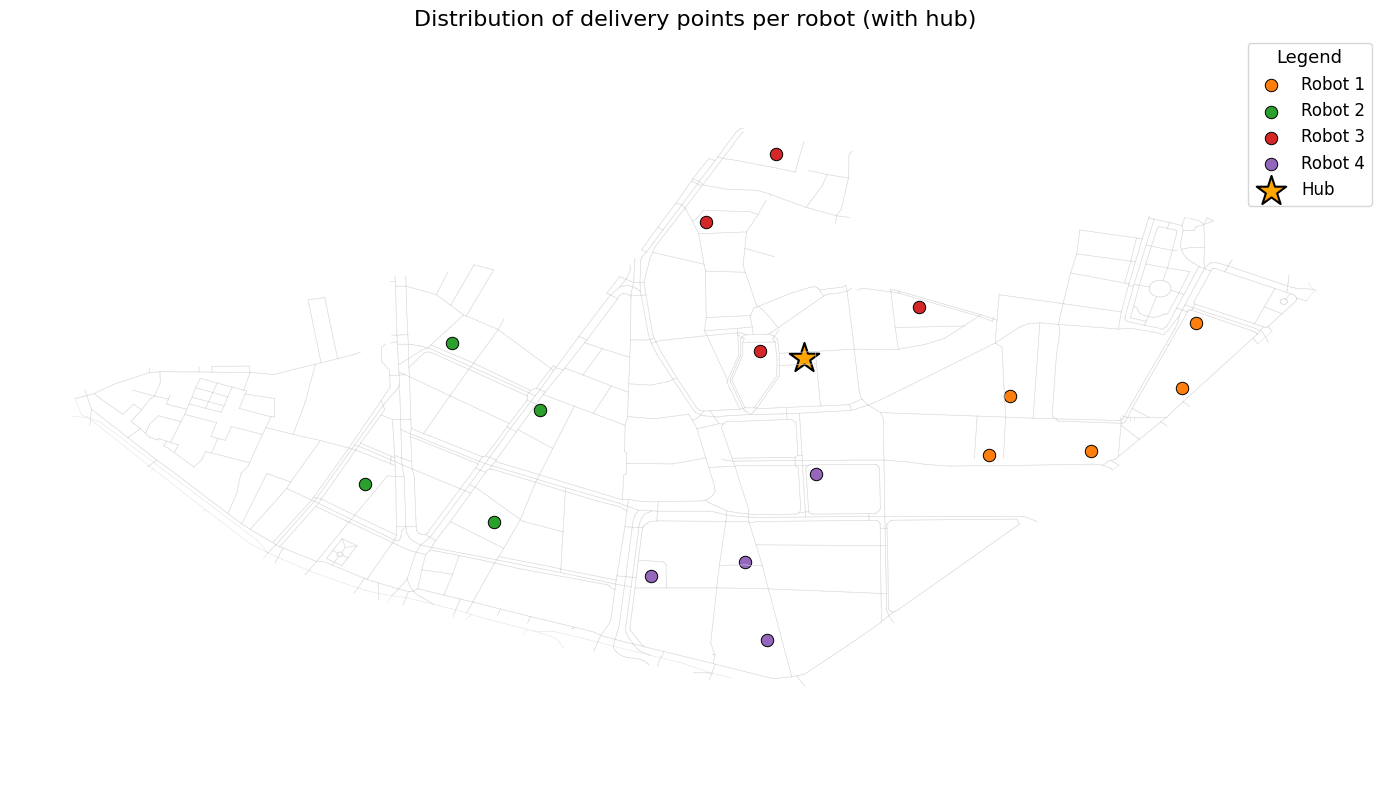

In [138]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.path import Path

# ==============================
# Visualize G_super + delivery points by cluster + fancy hub
# ==============================

fig, ax = plt.subplots(figsize=(14, 8))

# 1. Draw the edges of the supergraph (all streets)
for u, v, data in G_super.edges(data=True):
    if isinstance(u, str) or isinstance(v, str):
        continue
    x0, y0 = G_super.nodes[u]['x'], G_super.nodes[u]['y']
    x1, y1 = G_super.nodes[v]['x'], G_super.nodes[v]['y']
    ax.plot([x0, x1], [y0, y1], color='lightgray', linewidth=0.4, alpha=0.6)

# 2. Plot delivery points grouped by cluster
colors = list(mcolors.TABLEAU_COLORS.values()) + list(mcolors.CSS4_COLORS.values())
for group in sorted(bajos_sample['grupo_repartidor'].unique()):
    grp_pts = bajos_sample[bajos_sample['grupo_repartidor'] == group]
    xs, ys = grp_pts.geometry.x, grp_pts.geometry.y
    ax.scatter(xs, ys,
               s=80,
               color=colors[group % len(colors)],
               edgecolor='black',
               linewidth=0.7,
               label=f'Robot {group}')

# 4. Plot the hub 
hub_x = G_super.nodes[hub]['x']
hub_y = G_super.nodes[hub]['y']
ax.scatter(hub_x, hub_y,
           marker="*",
           s=500,                       # size of the marker
           facecolor='orange',          # fill color
           edgecolor='black',           # border color
           linewidth=1.5,
           label='Hub')

# 5. General plot style
ax.set_title("Distribution of delivery points per robot (with hub)", fontsize=16)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.axis('equal')
ax.axis('off')
ax.legend(title="Legend", fontsize=12, title_fontsize=13, loc='upper right')

plt.tight_layout()
plt.show()


### 3 Routing

In [139]:
# ==============================
# 1. FUNCIONES DE TIEMPO
# ==============================
def tiempo_por_distancia(distancia_metros, velocidad_kmh):
    """Convierte distancia en metros y velocidad en km/h a tiempo en minutos."""
    return distancia_metros / (velocidad_kmh * 1000 / 60)

def calcular_tiempos_en_aristas(G, VELOCIDAD_PEATON=5, VELOCIDAD_VEHICULO=35, VELOCIDAD_CONNECTION=10):
    """
    Añade a cada arista del grafo G los tiempos de caminata (tiempo_walk)
    y de conducción (tiempo_drive) según su modo ('walk','drive','connection').
    """
    for u, v, k, data in G.edges(keys=True, data=True):
        d     = data.get('length', 100)
        modos = data.get('mode', ['walk'])
        if 'connection' in modos:
            data['tiempo_walk']  = tiempo_por_distancia(d, VELOCIDAD_PEATON)
            data['tiempo_drive'] = tiempo_por_distancia(d, VELOCIDAD_CONNECTION)
            continue
        if 'walk' in modos:
            data['tiempo_walk'] = tiempo_por_distancia(d, VELOCIDAD_PEATON)
        if 'drive' in modos:
            v_kmh = data.get('maxspeed', VELOCIDAD_VEHICULO)
            if isinstance(v_kmh, str):
                v_kmh = int(''.join(filter(str.isdigit, v_kmh)) or VELOCIDAD_VEHICULO)
            data['tiempo_drive'] = tiempo_por_distancia(d, v_kmh)
        data.setdefault('tiempo_walk',  float('inf'))
        data.setdefault('tiempo_drive', float('inf'))

def calcular_tiempo_drive(origen, destino):
    """Ruta más rápida en vehículo entre origen y destino (minutos)."""
    try:
        camino = nx.shortest_path(G_super, origen, destino, weight='tiempo_drive')
    except nx.NetworkXNoPath:
        return float('inf'), None
    tiempo = 0.0
    for u, v in zip(camino[:-1], camino[1:]):
        ed    = G_super.get_edge_data(u, v)
        t_min = min(e['tiempo_drive'] for e in ed.values())
        tiempo += t_min
    return tiempo, camino

def calcular_tiempo_walk(origen, destino):
    """Ruta más rápida a pie entre origen y destino (minutos)."""
    try:
        camino = nx.shortest_path(G_super, origen, destino, weight='tiempo_walk')
    except nx.NetworkXNoPath:
        return float('inf'), None
    tiempo = 0.0
    for u, v in zip(camino[:-1], camino[1:]):
        ed    = G_super.get_edge_data(u, v)
        t_min = min(e['tiempo_walk'] for e in ed.values())
        tiempo += t_min
    return tiempo, camino

# ==============================
# 2. FUNCIONES AUXILIARES
# ==============================
def obtener_centroide_grupo(df_grupo):
    """Centroide geográfico de un DataFrame de geometrías."""
    return df_grupo.geometry.union_all().centroid

def distancia_euclidea(x1, y1, x2, y2):
    """Distancia euclídea en 2D."""
    return np.hypot(x1 - x2, y1 - y2)

def nodo_cid_mas_cercano(geom, nodos_cid):
    """Nodo CiD más cercano por distancia euclídea."""
    coords = [(G_super.nodes[n]['y'], G_super.nodes[n]['x']) for n in nodos_cid]
    tree   = cKDTree(coords)
    _, idx = tree.query((geom['y'], geom['x']))
    return nodos_cid[idx]

def calcular_matriz_distancias(pendientes, nodo_cid):
    """
    Matriz de distancias a pie entre todos los nodos pendientes + nodo CiD.
    """
    distancias = {}
    puntos     = pendientes['nodo'].tolist() + [nodo_cid]
    for n1 in puntos:
        distancias[n1] = {}
        for n2 in puntos:
            if n1 == n2:
                continue
            t, _ = calcular_tiempo_walk(n1, n2)
            distancias[n1][n2] = t
    return distancias

# ==============================
# 3. INICIALIZACIÓN
# ==============================

calcular_tiempos_en_aristas(G_super)

print("======= MODEL M2 TIME LOG =======\n")

grupos_pendientes = set(bajos_sample['grupo_repartidor'].unique())
entry_info = None
paquetes_camion = N_PAQUETES

# parámetro inicial para node-boundary
thresh = 0.00005

# contadores globales
tiempo_total_total = tiempo_drive_total = tiempo_walk_total = 0.0

# ==============================
# 4. ENTRADA HASTA EL CLUSTER (FASE 1)
# ==============================

inicio_furgoneta = None
ruta_drive = None


while entry_info is None:
    boundary_nodes = [
            n for n,d in G_drive.nodes(data=True)
            if shp_zone.boundary.distance(Point(d['x'], d['y'])) < thresh
        ]
    if not boundary_nodes or len(boundary_nodes) < 5:
        if thresh < 0.1:
                thresh = min(thresh * 3, 0.1)
                continue
        else:
            raise RuntimeError("No se encontró entrada válida para los clústeres restantes.")
            
    random.shuffle(boundary_nodes)

    # intentar encontrar entrada válida; si falla, aumentar thresh hasta 0.05
    cid_cand = nodo_cid_mas_cercano(G_super.nodes[hub], nodos_carga)
    for bnd in boundary_nodes:
        t_drive, camino = calcular_tiempo_drive(bnd, cid_cand)
        if camino and np.isfinite(t_drive):
            entry_info = (bnd, cid_cand, camino[1:], t_drive)
            break

    if entry_info is None:
        # si no encontramos y aún podemos aumentar thresh
        if thresh < 0.1:
            thresh = min(thresh * 3, 0.1)
            continue
        else:
            raise RuntimeError("No se encontró entrada válida para los clústeres restantes.")

    # desempaquetar entrada válida
    entry, nodo_cid, ruta_drive, tiempo_drive = entry_info
    inicio_furgoneta = entry
    ruta_drive = camino
    tiempo_drive_total += tiempo_drive

print("===🚛 PHASE 1: Driving Route into the CID 🚛===")
print(f"• Selected entry node (random): {entry}")
print(f"• Time to enter CID: {tiempo_drive_total:.1f} min\n")

# ==============================
# 5. DESCARGA DEL CAMIÓN (CID AL HUB) (FASE 2)
# ==============================

carga_actual = 0
rutas_descarga   = []
tiempos_descarga = []

print("===🏢 PHASE 2: Unloading Truck from CID to HUB 🏢===")


while paquetes_camion > 0:
    carga_actual = min(paquetes_camion, CAPACIDAD_MAXIMA_WALK)
    paquetes_camion -= carga_actual
    # calcular tiempo de ir del cid al hub
    t_ida, camino_ida = calcular_tiempo_walk(nodo_cid, hub)
    print(f"• {carga_actual} packages on foot from CID to HUB ({t_ida:.1f} min)")
    tiempo_walk_total += t_ida
    rutas_descarga.append(camino_ida[1:])
    tiempos_descarga.append(t_ida)

    if paquetes_camion != 0: # hay que volver al cid si aun quedan paquetes en el camion
        t_back, camino_back = calcular_tiempo_walk(hub, nodo_cid)
        print(f"  ↳ Returning on foot from HUB to CID ({t_back:.1f} min)")
        tiempo_walk_total += t_back
        rutas_descarga.append(camino_back[1:])
        tiempos_descarga.append(t_back)
print(f"• Truck fully unloaded. Total walking time: {tiempo_walk_total:.1f} min\n")
# ==============================
# 6. REPARTO DE PAQUETES POR CLUSTER (FASE 3)
# ==============================

rutas_y_tiempos   = []

print("===🤖 PHASE 3: ONA Deliveries from HUB 🤖===")

# preparativos para entregas a pie
while grupos_pendientes:
    grupo_sel = grupos_pendientes.pop()
    sub_bajos  = bajos_sample[bajos_sample['grupo_repartidor']==grupo_sel]
    pendientes = sub_bajos.copy()
    nodo_actual = hub
    carga_actual = 0
    rutas_walk_cluster   = []
    tiempos_walk_cluster = []
    tiempo_walk_cluster = 0.0

    print(f"\n  📍 ONA Nº{grupo_sel} route")
    print("    No.  |       Node        | Packages | Arrival (min)")
    print("    -----+-------------------+----------+---------------")

    matriz_dist = calcular_matriz_distancias(pendientes, hub)

    # nearest‐neighbor greedy + recarga
    while not pendientes.empty:
        dist_map = { n: matriz_dist[nodo_actual][n] for n in pendientes['nodo'] }
        nodo_sig = min(dist_map, key=dist_map.get)
        pkgs     = pendientes.loc[pendientes['nodo']==nodo_sig, 'paquetes'].item()

        # recargar si excede capacidad
        if carga_actual + pkgs > CAPACIDAD_MAXIMA_ONA:
            t_back, camino_back = calcular_tiempo_walk(nodo_actual, hub)
            dist_back = sum(
                G_super.get_edge_data(u,v)[0]['length']
                for u,v in zip(camino_back[:-1], camino_back[1:])
            )
            tiempo_walk_cluster += t_back
            rutas_walk_cluster[-1] = rutas_walk_cluster[-1] + camino_back[1:]
            nodo_actual = hub
            carga_actual = 0
            continue

        # entrega
        t_ida, camino_ida = calcular_tiempo_walk(nodo_actual, nodo_sig)
        dist_ida = sum(
            G_super.get_edge_data(u,v)[0]['length']
            for u,v in zip(camino_ida[:-1], camino_ida[1:])
        )
        tiempo_walk_cluster += t_ida
        rutas_walk_cluster.append(camino_ida[1:])
        tiempos_walk_cluster.append(tiempo_walk_cluster)

        
        print(f"    {len(rutas_walk_cluster):>3}  | {nodo_sig:<17} | {pkgs:^8} | {tiempo_walk_cluster:>13.2f}")
     

        carga_actual += pkgs
        pendientes = pendientes[pendientes['nodo']!=nodo_sig]
        nodo_actual = nodo_sig


        

    # almacenar resultados
    rutas_y_tiempos.append({
        'grupo_repartidor': grupo_sel,
        'tiempo_walk':      tiempo_walk_cluster,
        'rutas_walk':       rutas_walk_cluster,
        'tiempos_walk':     tiempos_walk_cluster
    })

    tiempo_walk_total  += tiempo_walk_cluster

total_onas = sum(x['tiempo_walk'] for x in rutas_y_tiempos)
print(f"\n🤖 Total ONAs deployment time: {total_onas:.1f} min")


tiempo_total_total = tiempo_drive_total + tiempo_walk_total

# ==============================
# 5. RESULTADOS FINALES
# ==============================
df_rutas_y_tiempos = pd.DataFrame(rutas_y_tiempos)
print("\n===📦 OVERALL RESULTS 📦===")
print(f"⏱️ Total delivery time: {tiempo_total_total:.1f} min")
print(f"🚐 Total driving time:  {tiempo_drive_total:.1f} min")
print(f"🚶‍♂️ Total walking time: {tiempo_walk_total:.1f} min\n")



======= MODEL M2 TIME LOG =======

===🚛 PHASE 1: Driving Route into the CID 🚛===
• Selected entry node (random): 297664565
• Time to enter CID: 0.3 min

===🏢 PHASE 2: Unloading Truck from CID to HUB 🏢===
• 8 packages on foot from CID to HUB (0.9 min)
  ↳ Returning on foot from HUB to CID (0.9 min)
• 8 packages on foot from CID to HUB (0.9 min)
  ↳ Returning on foot from HUB to CID (0.9 min)
• 8 packages on foot from CID to HUB (0.9 min)
  ↳ Returning on foot from HUB to CID (0.9 min)
• 8 packages on foot from CID to HUB (0.9 min)
  ↳ Returning on foot from HUB to CID (0.9 min)
• 8 packages on foot from CID to HUB (0.9 min)
• Truck fully unloaded. Total walking time: 8.4 min

===🤖 PHASE 3: ONA Deliveries from HUB 🤖===

  📍 ONA Nº1 route
    No.  |       Node        | Packages | Arrival (min)
    -----+-------------------+----------+---------------
      1  | comercio_21925    |    1     |          3.66
      2  | comercio_21906    |    2     |          5.22
      3  | comercio_21892    

### 4 Results mapping

In [ ]:
import folium
import math
import numpy as np
from folium import Marker, PolyLine, CircleMarker, GeoJson, LayerControl
from folium.plugins import MarkerCluster
from folium.features import DivIcon
import matplotlib.colors as mcolors
from collections import defaultdict

# 1️⃣ Colores por cluster
cluster_ids = sorted(bajos_sample['grupo_repartidor'].unique())
base_colors = list(mcolors.TABLEAU_COLORS.values())
cluster_colors = {
    cid: base_colors[i % len(base_colors)]
    for i, cid in enumerate(cluster_ids)
}

# 2️⃣ Calcula order_map (número de entrega por comercio)
order_map = {}
for _, row in df_rutas_y_tiempos.iterrows():
    grp   = row['grupo_repartidor']
    rutas = row['rutas_walk']
    order_map[grp] = {
        path[-1]: idx
        for idx, path in enumerate(rutas, start=1)
    }

# 3️⃣ Prepara lista de puntos: comercios, CID y HUB
items = []
for _, r in bajos_sample.iterrows():
    nodo, grp = r['nodo'], r['grupo_repartidor']
    y, x       = G_super.nodes[nodo]['y'], G_super.nodes[nodo]['x']
    items.append((y, x, 'comercio', nodo, grp))
if ruta_drive:
    cid = ruta_drive[-1]
    y, x = G_super.nodes[cid]['y'], G_super.nodes[cid]['x']
    items.append((y, x, 'cid', cid, None))
y_hub, x_hub = G_super.nodes[hub]['y'], G_super.nodes[hub]['x']
items.append((y_hub, x_hub, 'hub', hub, None))

# 4️⃣ Agrupa por ubicación para evitar solapamientos
loc_groups = defaultdict(list)
for it in items:
    loc = (round(it[0],6), round(it[1],6))
    loc_groups[loc].append(it)

# 5️⃣ Crea el mapa con fondo CartoDB Positron
centro = [
    np.mean([d['y'] for _, d in G_super.nodes(data=True)]),
    np.mean([d['x'] for _, d in G_super.nodes(data=True)])
]
m = folium.Map(location=centro, zoom_start=16, tiles="CartoDB Positron")

# 6️⃣ Dibuja tu zona (shapefile)
GeoJson(
    shp_zone,
    style_function=lambda f: {
        "color":"green","weight":4,
        "fillColor":"limegreen","fillOpacity":0.1
    }
).add_to(m)

# 7️⃣ [ELIMINADO] grafo de fondo

# 8️⃣ Añade marcadores: comercios (+número), CID y HUB
R = 7
for (lat0, lon0), group in loc_groups.items():
    if len(group) > 1:
        folium.Circle(
            location=(lat0, lon0), radius=10,
            color="black", weight=1,
            fill=True, fill_color="black", fill_opacity=0.2
        ).add_to(m)
    for idx, (lat, lon, tipo, nodo, grp) in enumerate(group):
        if len(group) == 1:
            lat_j, lon_j = lat, lon
        else:
            angle = 2 * math.pi * idx / len(group)
            dlat  = (10 * math.cos(angle)) / 111000
            dlon  = (10 * math.sin(angle)) / (111000 * math.cos(math.radians(lat0)))
            lat_j, lon_j = lat0 + dlat, lon0 + dlon

        if tipo == 'comercio':
            color = cluster_colors[grp]
            CircleMarker(
                location=(lat_j, lon_j), radius=R,
                color=color, fill=True, fill_opacity=0.8
            ).add_to(m)
            nro = order_map[grp].get(nodo)
            if nro:
                Marker(
                    location=(lat_j, lon_j),
                    icon=DivIcon(
                        icon_size=(20,20),
                        html=(
                            f"<div style='font-size:12px;color:white;"
                            f"background:{color};border-radius:50%;"
                            f"width:20px;height:20px;line-height:20px;"
                            f"text-align:center;'>{nro}</div>"
                        )
                    )
                ).add_to(m)

        

        elif tipo != 'cid':  # hub
            Marker(
                location=(lat_j, lon_j),
                icon=DivIcon(icon_size=(24,24), html="<div style='font-size:18px;'>🏢</div>"),
                popup="HUB central"
            ).add_to(m)

# 9️⃣ Dibuja la ruta de la furgoneta: 🏁 inicio y 📍 fin
if ruta_drive:
    coords = [(G_super.nodes[n]['y'], G_super.nodes[n]['x']) for n in ruta_drive]
    PolyLine(coords, color="black", weight=5, opacity=0.6).add_to(m)
    y0, x0 = coords[0]
    Marker(
        location=(y0, x0),
        icon=DivIcon(icon_size=(24,24), html="<div style='font-size:18px;'>🏁</div>")
    ).add_to(m)
    yf, xf = coords[-1]
    Marker(
        location=(yf, xf),
        icon=DivIcon(icon_size=(24,24), html="<div style='font-size:18px;'>📍</div>")
    ).add_to(m)

# 1️⃣0️⃣ Agrega rutas a pie (ONAs)
fg_walk = MarkerCluster(name="Rutas a pie", show=True)
for _, row in df_rutas_y_tiempos.iterrows():
    grp   = row['grupo_repartidor']
    color = cluster_colors[grp]
    for caminata in row['rutas_walk']:
        coords_w = [(G_super.nodes[n]['y'], G_super.nodes[n]['x']) for n in caminata]
        PolyLine(coords_w, color=color, weight=2, opacity=0.9, dash_array="4,6").add_to(fg_walk)
fg_walk.add_to(m)

# 🔁 Control de capas
LayerControl(collapsed=False).add_to(m)

# Renderiza tu mapa en Jupyter:
m
